Complete the exercises below For **Assignment #4**.

Use **Markdown** cells for the non-code answers.

In this assignment we will work with the data underlying the *FiveThirtyEight* article ["Higher Rates Of Hate Crimes Are Tied To Income Inequality"](https://fivethirtyeight.com/features/higher-rates-of-hate-crimes-are-tied-to-income-inequality/).

Load the `tidymodels`, `readr`, and `moderndive` packages in the cell below.

In [4]:

library('tidymodels')
library('readr')
library('moderndive')


We can read the data from a **CSV file** at the following URL: [http://bit.ly/2ItxYg3](http://bit.ly/2ItxYg3).

Use the `read_csv` function to read the data into our R session. Call the new table `hate_crimes`.

In [12]:
hate_crimes = read_csv('http://bit.ly/2ItxYg3') 

head()


Rows: 51 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): state, median_house_inc, trump_support, unemployment, urbanization
dbl (4): share_pop_metro, hs, hate_crimes, income

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [15]:
head(hate_crimes)

state,median_house_inc,share_pop_metro,hs,hate_crimes,trump_support,unemployment,urbanization,income
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
New Mexico,low,0.69,83,0.295,low,high,low,46686
Maine,low,0.54,90,0.616,low,low,low,51710
New York,low,0.94,85,0.351,low,low,high,54310
Illinois,low,0.90,86,0.195,low,high,high,54916
Delaware,high,0.90,87,0.323,low,low,high,57522
Rhode Island,high,1.00,85,0.095,low,high,high,58633


Next, let’s add the high-school degree variable into the mix by creating a scatterplot showing:

- Income on the y-axis (this is the `income` variable)
- Percent of adults 25 or older with a high school degree on the x-axis (this is the `hs` variable)
- The points colored by level of urbanization in a region (this is the variable `urbanization`)


**In addition, add a line of best fit (regression line) for each level of the variable urbanization (one for “low”, one for “high”).**

*Add the regression lines to the plot using the `geom_parallel_slopes` function from the `moderndive` package. This function will draw the regression lines based on fitting a regression model with parallel slopes (i.e., with no interaction between `hs` and `urbanization`).*

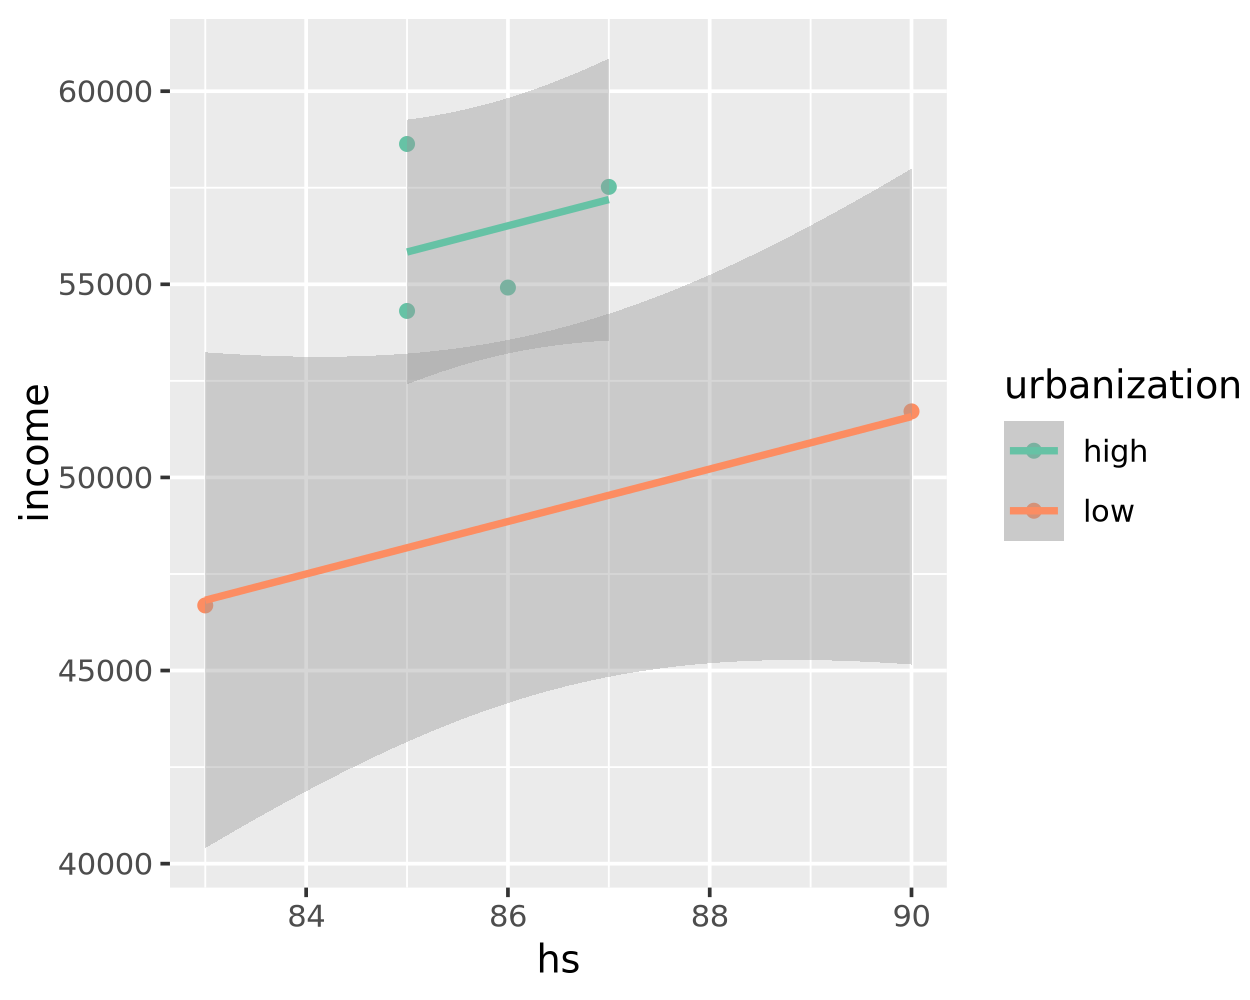

In [24]:

p = ggplot(hate_crimes, aes(x = hs ,y = income, color = urbanization)) + geom_point(na.rm = T) + scale_color_brewer(palette = 'Set2') + moderndive::geom_parallel_slopes()



p

❓Which regression line (high urbanization or low urbanization) appears to have the larger intercept?

**Answer:**


high appears to have the larger interception


Now let’s create a second scatterplot using the same variables, but this time draw the regression lines using `geom_smooth(method = "lm")`, which will allow for separate, non-parallel slopes for each urbanization group. 

**Code your scatter plot in the cell below.**

`geom_smooth()` using formula = 'y ~ x'
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


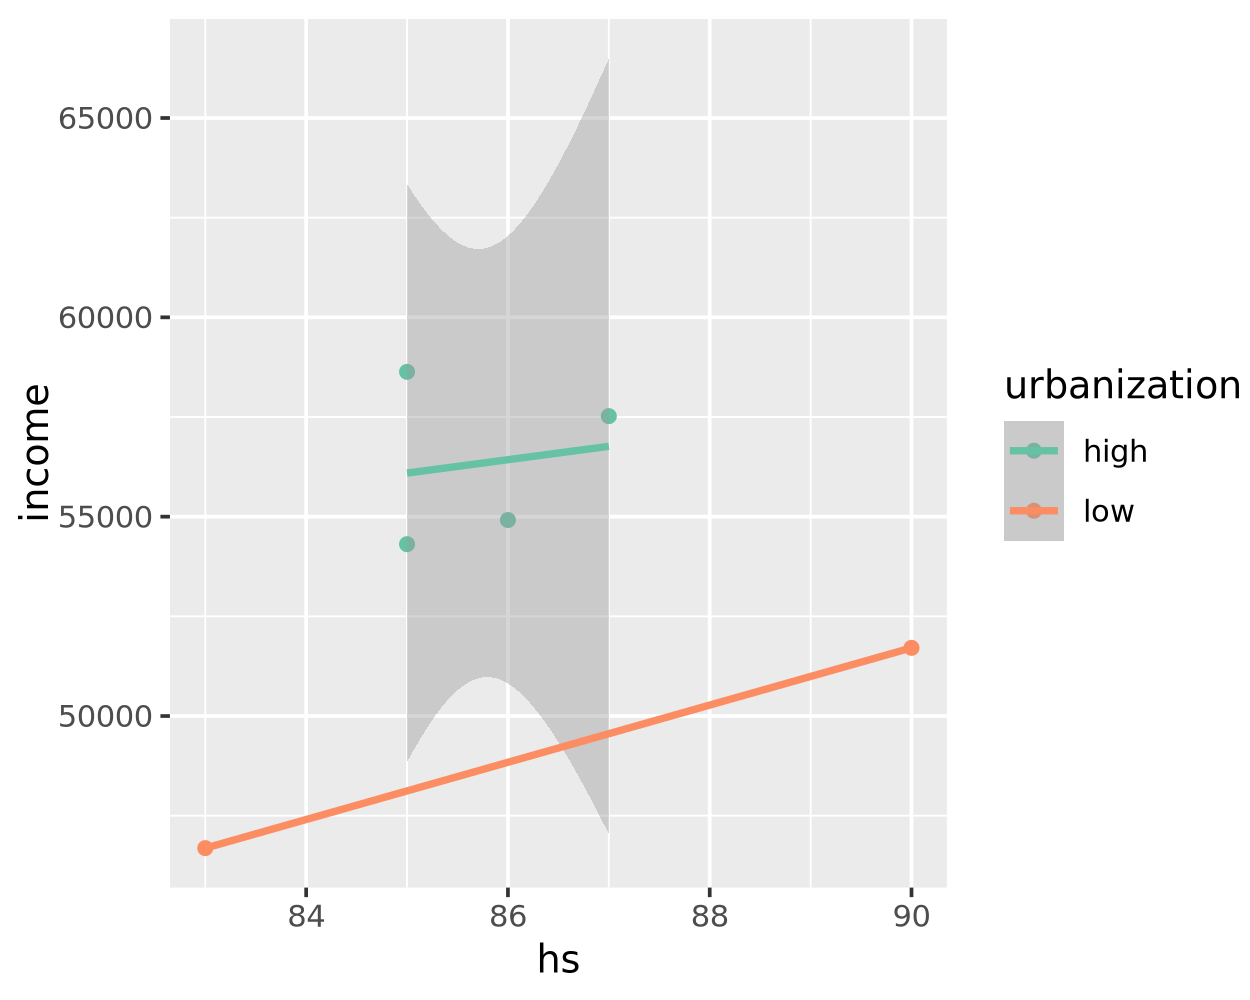

In [33]:
x = ggplot (hate_crimes, aes(x = hs, y = income, color = urbanization)) + geom_point(na.rm = T) + scale_color_brewer(palette = 'Set2') + geom_smooth(method = 'lm')






x

❓Based on visually comparing the two models shown above, do you think it would be best to run a “parallel slopes” model (i.e. a model that estimates one shared slope for the two levels of urbanization), or a more complex “interaction model” (i.e. a model that estimates a separate slope for the two levels of urbanization)?

**Answer:**

parallel slopes  model since the slopes are similar for both high and low



Fit the following two regression models that examine the relationship between household `income` (as response variable), and high-school education (`hs`) and `urbanization` as explanatory variables:

1. A parallel slopes model (i.e., no interaction between `hs` and `urbanization`). ❗️Save the data recipe and model under the variables `ps_rec` and `ps_mod`, respectively. 
1. A non-parallel slopes model (i.e., allow `hs` and `urbanization` to interact in your model). ❗️Save the data recipe and model under the variable: `nps_rec` and `nps_mod`, respectively.

**Code you your models in the cell below.**

In [54]:
# parallel slopes model

ps_rec = recipe(income ~ hs + urbanization, data = hate_crimes) |> 
    step_naomit(everything()) |>   # remove missing values
    step_dummy(urbanization) |>    # dummy encode the urbanization variable
    prep()                         # run the recipe on the training data provided

mod = linear_reg() |> set_engine('lm')

ps_mod = mod |> fit(income ~ ., juice(ps_rec))

ps_mod

parsnip model object


Call:
stats::lm(formula = income ~ ., data = data)

Coefficients:
     (Intercept)                hs  urbanization_low  
         -1896.3             679.2           -7656.7  


In [55]:
# non-parallel slopes model

# ❗️ you can use most of the code above, just add step_interact(~ starts_with("urbanization"):hs) to the recipe and
#    switch the variable names...

nps_rec = recipe(income ~ hs + urbanization, data = hate_crimes) |> 
    step_naomit(everything()) |>   # remove missing values
    step_dummy(urbanization) |> # dummy encode the urbanization variable
    step_interact(~ starts_with("urbanization"):hs) |>
    prep()                         # run the recipe on the training data provided

mod = linear_reg() |> set_engine('lm')

nps_mod = mod |> fit(income ~ ., juice(nps_rec))

nps_mod



parsnip model object


Call:
stats::lm(formula = income ~ ., data = data)

Coefficients:
          (Intercept)                     hs       urbanization_low  
              27525.5                  336.1               -40409.7  
urbanization_low_x_hs  
                381.6  


The following code creates a table of your model predictions over the training data. Calculate the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) (R<sup>2</sup>) for each model:

```r
rbind(
    augment(ps_mod, juice(ps_rec)) |> select(income, .pred, .resid) |> mutate(model = "parallel_slopes"),
    augment(nps_mod, juice(nps_rec)) |> select(income, .pred, .resid) |> mutate(model = "interaction")
)
```

1. Group rows by the `model` variable (use the `group_by` function).
1. Calculate the variance of income over the variance of your predictions for each model using the "grouped" data from the step above (use `summarize(r_squared = var(.pred) / var(income))`).

In [56]:
mod_pred = rbind(
    augment(ps_mod, juice(ps_rec)) |> select(income, .pred, .resid) |> mutate(model = "parallel_slopes"),
    augment(nps_mod, juice(nps_rec)) |> select(income, .pred, .resid) |> mutate(model = "interaction")
)



gpd_data = mod_pred |> group_by(model) |> summarize(r_squared = var(.pred) / var(income))


In [58]:
head(gpd_data)

model,r_squared
<chr>,<dbl>
interaction,0.8664356
parallel_slopes,0.8625859


🎶 Note: you can also use the `glance` function with a model as input to find the coefficient of determination.

In [59]:
glance(nps_mod)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.8664356,0.6660891,2499.291,4.324685,0.1934998,3,-52.16037,114.3207,113.2795,12492907,2,6


In [60]:
glance(ps_mod)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.8625859,0.7709765,2069.862,9.415912,0.05093858,2,-52.24561,112.4912,111.6583,12852989,3,6


❓Compare the adjusted proportion of variance accounted for in each model. Based on this comparison, which model do you prefer? Why? 

**Answer:**

In [ ]:
I would use the parallel slope model since it has the highest adjusted r squared



❓Using your preferred model, based on your regression model parameters (and the data visualizations), is `income` greater in states that have lower or higher levels of `urbanization`? By how much?

**Hint:** use the `tidy` function with your model as input to access the parameters in a nice table.

**Answer:**

In [66]:

model_summary <- tidy(ps_mod)

print(model_summary)

# A tibble: 3 × 5
  term             estimate std.error statistic p.value
  <chr>               <dbl>     <dbl>     <dbl>   <dbl>
1 (Intercept)        -1896.    34017.   -0.0557  0.959 
2 hs                   679.      397.    1.71    0.185 
3 urbanization_low   -7657.     1817.   -4.21    0.0244


income is greater in states that have higher levels of urbanization 

❓For every one percentage point increase of high-school educated adults in a state (`hs` variable), what is the associated average increase in `income`?

**Answer:**

In [67]:
model_summary <- tidy(nps_mod)

print(model_summary)



# A tibble: 4 × 5
  term                  estimate std.error statistic p.value
  <chr>                    <dbl>     <dbl>     <dbl>   <dbl>
1 (Intercept)             27525.   129242.     0.213   0.851
2 hs                        336.     1507.     0.223   0.844
3 urbanization_low       -40410.   136434.    -0.296   0.795
4 urbanization_low_x_hs     382.     1589.     0.240   0.833


$336